# Intro to Regularization



In [1]:
%pylab inline

# Necessary imports
import pandas as pd
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
sns.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [14]:
import pickle

# Getting back the objects:
with open('objs_steam_data.pkl', 'rb') as f:
    y, X, steamDB_users_df_fuzzy_final, steamDB_users_df_fuzzy, steamDB_users_df, steam_combined_expanded, steam_combined_fuzzy = pickle.load(f)
f.close()

In [22]:
with open('X.pkl', 'rb') as f:
    X = pickle.load(f)
f.close()

with open('y.pkl', 'rb') as f:
    y = pickle.load(f)
f.close()

with open('steam_combined_expanded_fuzzy.pkl', 'rb') as f:
    steam_combined_expanded_fuzzy = pickle.load(f)
f.close()

In [24]:
x = X
#y = y[:,1] # getting rid of the index in my y
y.head()

0    1951.0
1    3879.0
2     189.0
3      36.0
4    2002.0
Name: All_Time_Peak_concurrent_users, dtype: float64

# Data

Using data from Steam


In [25]:
#df_ames = pd.read_csv("~/.kaggle/competitions/house-prices-advanced-regression-techniques/train.csv")
steam_combined_expanded_fuzzy.head()

,Developer,Genre,Publisher,Release_Date,Title,app_id,app_name,discount_price,early_access,esrb,...,violentmature_reasons_new,visit,withmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t],early_access[T.True]
0,[WTFOMGames],"[Action, Adventure, Casual, Indie]",[WTFOMGames],"Mar 1, 2016",! That Bastard Is Trying To Steal Our Gold !,449940,! That Bastard Is Trying To Steal Our Gold !,3.99,False,nr,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,[Beatshapers],"[Action, Indie]","[8Floor, Beatshapers]","Aug 10, 2016",#KILLALLZOMBIES,303720,#KILLALLZOMBIES,4.99,False,t,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,[Paleno Games],"[Casual, Indie]",[Paleno Games],"May 5, 2017",#monstercakes,614910,#monstercakes,0.99,False,nr,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,[Eko],"[Adventure, Indie]",[Eko],"Mar 14, 2018",#WarGames,779420,#WarGames,2.99,False,nr,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,[BeHappy Studios],"[Action, Casual, Indie]",[Back To Basics Gaming],"Jul 28, 2016",$1 Ride,508290,$1 Ride,0.98,False,nr,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Diagnosing Under/Overfitting

How do we tell if we're overfit or underfit? First, let's look at a case where the answer might be ambiguous.

We will grab all numeric columns from the dataframe and then build a learning curve with standard OLS

In [186]:
# first grab those numeric features!
df_num = df_ames.select_dtypes(["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [187]:
#x = df_num.drop(columns=["Id", "SalePrice"])
#y = df_num["SalePrice"]

In [7]:
# sklearn imports
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing

In [66]:
x.head()

,discount_price,metascore,overall_rev_pos_perc,overall_reviews_n,price,recent_rev_pos_perc,recent_reviews_n,steam_Achievement_n,fuzzy_score,1980s,...,violentmature_reasons_new,visit,withmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t],early_access[T.True]
0,3.99,0.0,46.0,15.0,3.99,0.0,NaN,0.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.99,0.0,47.0,19.0,4.99,0.0,NaN,10.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.99,0.0,90.0,272.0,0.99,80.0,NaN,18.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.99,0.0,66.0,54.0,2.99,0.0,NaN,55.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.98,0.0,58.0,80.0,0.98,0.0,NaN,0.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [67]:
# remove columns with low values (sum<10)

print('number of observations:', len(x))
print('number of features:', len(x.columns))

x.drop([col for col, val in x.sum().iteritems() if val < 10], axis=1, inplace=True)

# add intercept back in
x['Intercept'] = 1.0 

print('number of features after removing columns with low values:',len(x.columns))

number of observations: 7295
number of features: 9856
number of features after removing columns with low values: 845


In [103]:
x.head()

,discount_price,metascore,overall_rev_pos_perc,overall_reviews_n,price,recent_rev_pos_perc,recent_reviews_n,steam_Achievement_n,fuzzy_score,1980s,...,users,violence,violentmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t],early_access[T.True]
0,3.99,0.0,46.0,15.0,3.99,0.0,NaN,0.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.99,0.0,47.0,19.0,4.99,0.0,NaN,10.0,100.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.99,0.0,90.0,272.0,0.99,80.0,NaN,18.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.99,0.0,66.0,54.0,2.99,0.0,NaN,55.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.98,0.0,58.0,80.0,0.98,0.0,NaN,0.0,100.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [104]:
x.drop(['fuzzy_score'], axis=1, inplace=True)

In [316]:
OLS_pipe = pipeline.Pipeline(
    # some features have missing values so this fills in the mean for them
    # this imputer is lazy and often helpful but not always the best option
    [("imp", preprocessing.Imputer()), 
     # this removes zero variance features:
     ("var", feature_selection.VarianceThreshold()),
     # scale our features before linear models. it's good data hygiene 
     ("std", preprocessing.StandardScaler()),
     # our old friend <3
     ("lin", linear_model.LinearRegression())
    ])

In [317]:
cv_y = y

cv_result = model_selection.cross_validate(
        OLS_pipe, X=x, y=cv_y, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

train: 0.412, test: -1.43e+25


In [227]:
select_pipe = pipeline.Pipeline(
    # some features have missing values so this fills in the mean for them
    # this imputer is lazy and often helpful but not always the best option
    [("imp", preprocessing.Imputer()), 
     # this removes zero variance features:
     ("var", feature_selection.VarianceThreshold()),
     # scale our features before linear models. it's good data hygiene 
     ("std", preprocessing.StandardScaler()),
     # we'll use select k best to adjust model complexity
     ("select",
      feature_selection.SelectKBest(k=10,
          score_func=feature_selection.f_regression)), 
     # our old friend <3
     ("lin", linear_model.LinearRegression())
    ])

Wait, so what's a pipeline? It's a handy tool to combine sklearn "estimators". The above steps would've taken several lines of code to do by hand. We'd have to fit_transform the imputer, fit_transform the standard scaler on train and then just transform on test, etc. etc. Pipelines automate those repetitive steps for your workflow

In [92]:
# previously our code looked like this

# imp = preprocessing.Imputer()
# new_x, new_y = imp.fit_transform(x,y)

# ...

# lr = linear_model.LinearRegression()
# lr.fit(new_x, new_y)
# lr.score(new_x, new_y)

In [93]:
select_pipe.get_params()

{'memory': None,
 'steps': [('imp',
   Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)),
  ('var', VarianceThreshold(threshold=0.0)),
  ('std', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('select',
   SelectKBest(k=2, score_func=<function f_regression at 0x10d55bd08>)),
  ('lin',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))],
 'imp': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'var': VarianceThreshold(threshold=0.0),
 'std': StandardScaler(copy=True, with_mean=True, with_std=True),
 'select': SelectKBest(k=2, score_func=<function f_regression at 0x10d55bd08>),
 'lin': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'imp__axis': 0,
 'imp__copy': True,
 'imp__missing_values': 'NaN',
 'imp__strategy': 'mean',
 'imp__verbose': 0,
 'var__threshold': 0.0,
 'std__copy': True,
 'std__with_mean': True,
 'std__with_std': True,
 'select__k': 2,
 'sel

In [232]:
select_y=log(y)

# now it's just
select_pipe.fit(x,select_y)
select_pipe.score(x,select_y)

0.4470857220413196

In [ ]:
select_pred = select_pipe.predict(x)

In [229]:
# okay but how do we get to the model underneath? 
# use .named_steps. Here's how we would find the coefs

# first find out which fetures were selected
feat_support_var = select_pipe.named_steps["var"].get_support()
feat_var = x.columns[feat_support_var]




select_support = select_pipe.named_steps["select"].get_support()
select_feat = feat_var[select_support]



coef = select_pipe.named_steps["lin"].coef_


list(zip(feat, coef))

[('discount_price', 19999.114731628768),
 ('metascore', 1278.0476087302811),
 ('overall_rev_pos_perc', 1222.9442277864596),
 ('overall_reviews_n', 2245.3153201385626),
 ('price', 1496.5336479490818),
 ('recent_rev_pos_perc', 677.2985247433261),
 ('recent_reviews_n', 4312.236707314003),
 ('steam_Achievement_n', -1784.0977483984502),
 ('1980s', 4447.772258636796),
 ('1990', 4447.772258636796)]

Okay, how do we diagnose overfitting? Well the very first step is to look at cross validated train vs test performance. Let's keep everything at its defaults and see how we do. 

In [315]:
cv_y = y

cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=cv_y, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

train: 0.329, test: -2.11


In [331]:
test_train_y = y
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,test_train_y)

In [333]:
select_pred = select_pipe.predict(x_test)
select_pipe.score(x_test, y_test)

-0.009116555798309056

In [ ]:
# calculate r-squared for a log(y)

select_pred = select_pipe.predict(x_test)

y_pred = exp(select_pred)

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared, SSR, SST)

In [330]:
# calculate r-squared for a log(y)

select_pred = select_pipe.predict(x_test)

y_pred = exp(select_pred)

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared, SSR, SST)

0.0012619317824042334 18123693707.574432 14361864849021.52


In [335]:
# okay but how do we get to the model underneath? 
# use .named_steps. Here's how we would find the coefs

# first find out which fetures were selected
feat_support_var = select_pipe.named_steps["var"].get_support()
feat_var = x.columns[feat_support_var]




select_support = select_pipe.named_steps["select"].get_support()
select_feat = feat_var[select_support]



coef = select_pipe.named_steps["lin"].coef_


list(zip(feat, coef))

[('discount_price', 0.35191321764886785),
 ('metascore', 0.5427651876621874),
 ('overall_rev_pos_perc', 0.06471729618599727),
 ('overall_reviews_n', 0.44041114779194246),
 ('price', 0.06471729618599707),
 ('recent_rev_pos_perc', 0.20732552893908276),
 ('recent_reviews_n', 0.12486045021661757),
 ('steam_Achievement_n', 0.2207162479411279),
 ('1980s', 0.30148250975401025),
 ('1990', 0.3014825097540103)]

Okay, they're pretty darn close. Maybe that means we're underfit (adding model complexity would help us). Maybe that means we're perfect. Only way to find out is to look at a learning curve

In [72]:
figsize(15, 8)


train_scores = []
test_scores = []
# define feature range
num_feats = len(x.columns)
feat_range = np.arange(1, num_feats, 10)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    select_pipe.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    print(f"feature {num_f} done")

# plot test vs train
plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();

feature 1 done
feature 2 done
feature 3 done
feature 4 done
feature 5 done
feature 6 done
feature 7 done
feature 8 done
feature 9 done
feature 10 done
feature 11 done
feature 12 done
feature 13 done
feature 14 done
feature 15 done
feature 16 done
feature 17 done
feature 18 done
feature 19 done
feature 20 done
feature 21 done
feature 22 done
feature 23 done
feature 24 done
feature 25 done
feature 26 done
feature 27 done
feature 28 done
feature 29 done
feature 30 done
feature 31 done
feature 32 done
feature 33 done
feature 34 done
feature 35 done
feature 36 done
feature 37 done
feature 38 done
feature 39 done
feature 40 done
feature 41 done
feature 42 done
feature 43 done
feature 44 done
feature 45 done
feature 46 done
feature 47 done
feature 48 done
feature 49 done
feature 50 done
feature 51 done
feature 52 done
feature 53 done
feature 54 done
feature 55 done
feature 56 done
feature 57 done
feature 58 done
feature 59 done
feature 60 done
feature 61 done
feature 62 done
feature 63 done
f

KeyboardInterrupt: 

Is this overfit? Idk, you tell me. It's difficult to say if adding more features would worsen test performance or not.

In a case like this, looking at feature selection or regularization might help, or doing the opposite and adding new features might help, but it's also possible that neither will.

Let's add a whole bunch of features and see

In [ ]:
%matplotlib inline

# load the R package ISLR
infert = com.importr("ISLR")

# load the Auto dataset
auto_df = com.load_data('Auto')

plot_df = 

# calculate the correlation matrix
corr = auto_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [60]:
steam_combined_expanded_fuzzy_test = steam_combined_expanded_fuzzy.copy()
steam_combined_expanded_fuzzy_test.drop([col for col, val in steam_combined_expanded_fuzzy_test.sum().iteritems() if val < 10], axis=1, inplace=True)

7295

In [61]:
len(steam_combined_expanded_fuzzy_test.columns)

871

In [ ]:
steam_combined_expanded_fuzzy[column].sum()<10

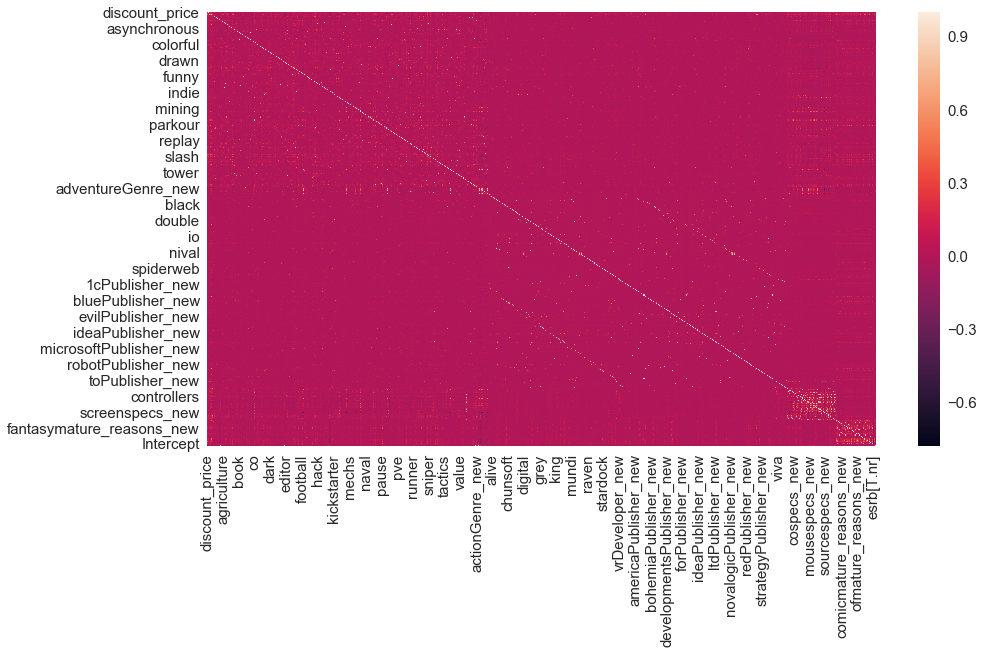

In [292]:
#plot_df=steam_combined_expanded_fuzzy.select_dtypes(include=['int64','float64']).iloc[:,1:200]
plot_df=x.select_dtypes(include=['int64','float64'])

#plot_df = plot_df.drop(['fuzzy_score'], axis=1)
plot_df.head()
sns.heatmap(plot_df.corr())

In [304]:
steam_combined_expanded_fuzzy.discount_price = steam_combined_expanded_fuzzy.discount_price.astype(float)

In [309]:
steam_combined_expanded_fuzzy.discount_price.head()

0    3.99
1    4.99
2    0.99
3    2.99
4    0.98
Name: discount_price, dtype: float64

In [307]:
steam_combined_expanded_fuzzy.recent_reviews_n = steam_combined_expanded_fuzzy.recent_reviews_n.str.replace(',','').astype(float)

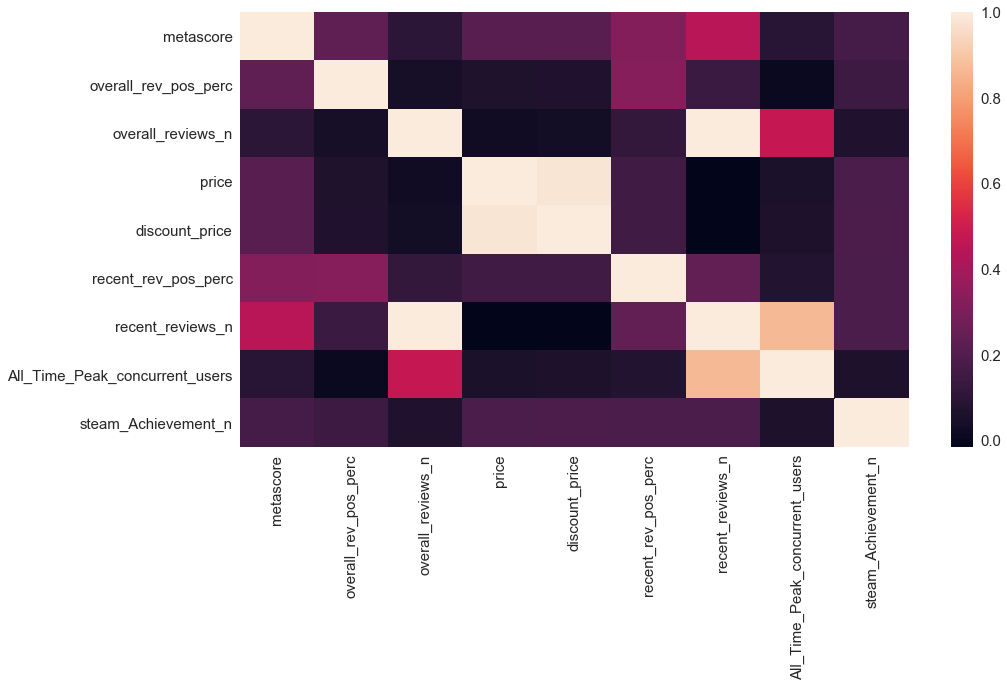

In [314]:
plot_df=steam_combined_expanded_fuzzy.select_dtypes(include=['int64','float64'])
#plot_df = plot_df.drop(['fuzzy_score'], axis=1)
plot_df = plot_df[['metascore', 'overall_rev_pos_perc', 'overall_reviews_n','price','discount_price','recent_rev_pos_perc', 'recent_reviews_n','All_Time_Peak_concurrent_users','steam_Achievement_n']]

#plot_df=x.select_dtypes(include=['int64','float64'])

plot_df.head()
sns.heatmap(plot_df.corr())

In [200]:
# how do we quickly get dummies for all of our object/categorical features? This handy tool!
# CAUTION be careful with this one. If you have object features that are different for every row
# it'll try to make a new column for each value

# want an easy way to deal with NAs? add a dummy column for them!
df_full = pd.get_dummies(df_full, dummy_na=True, drop_first=True)
df_full.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MoSold_9.0,MoSold_10.0,MoSold_11.0,MoSold_12.0,MoSold_nan,YrSold_2007.0,YrSold_2008.0,YrSold_2009.0,YrSold_2010.0,YrSold_nan
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,0,0,1,0,0,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,1,0,0,0,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,1,0,0,0,0,0,1,0,0,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,0,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,1,0,0,0


## Visualizing Overfitting: The need for Regularization

Now let's look at select k best when we have 300+ features!

In [204]:
# some of the NA columns we created have all zeros. this can cause errors 
# so we're introducing variance threshold to remove those columns
select_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()),
    ("var", feature_selection.VarianceThreshold()),
    ("select", feature_selection.SelectKBest( score_func=feature_selection.f_regression)),
    ("std", preprocessing.StandardScaler()),
    ("lin", linear_model.LinearRegression())
])

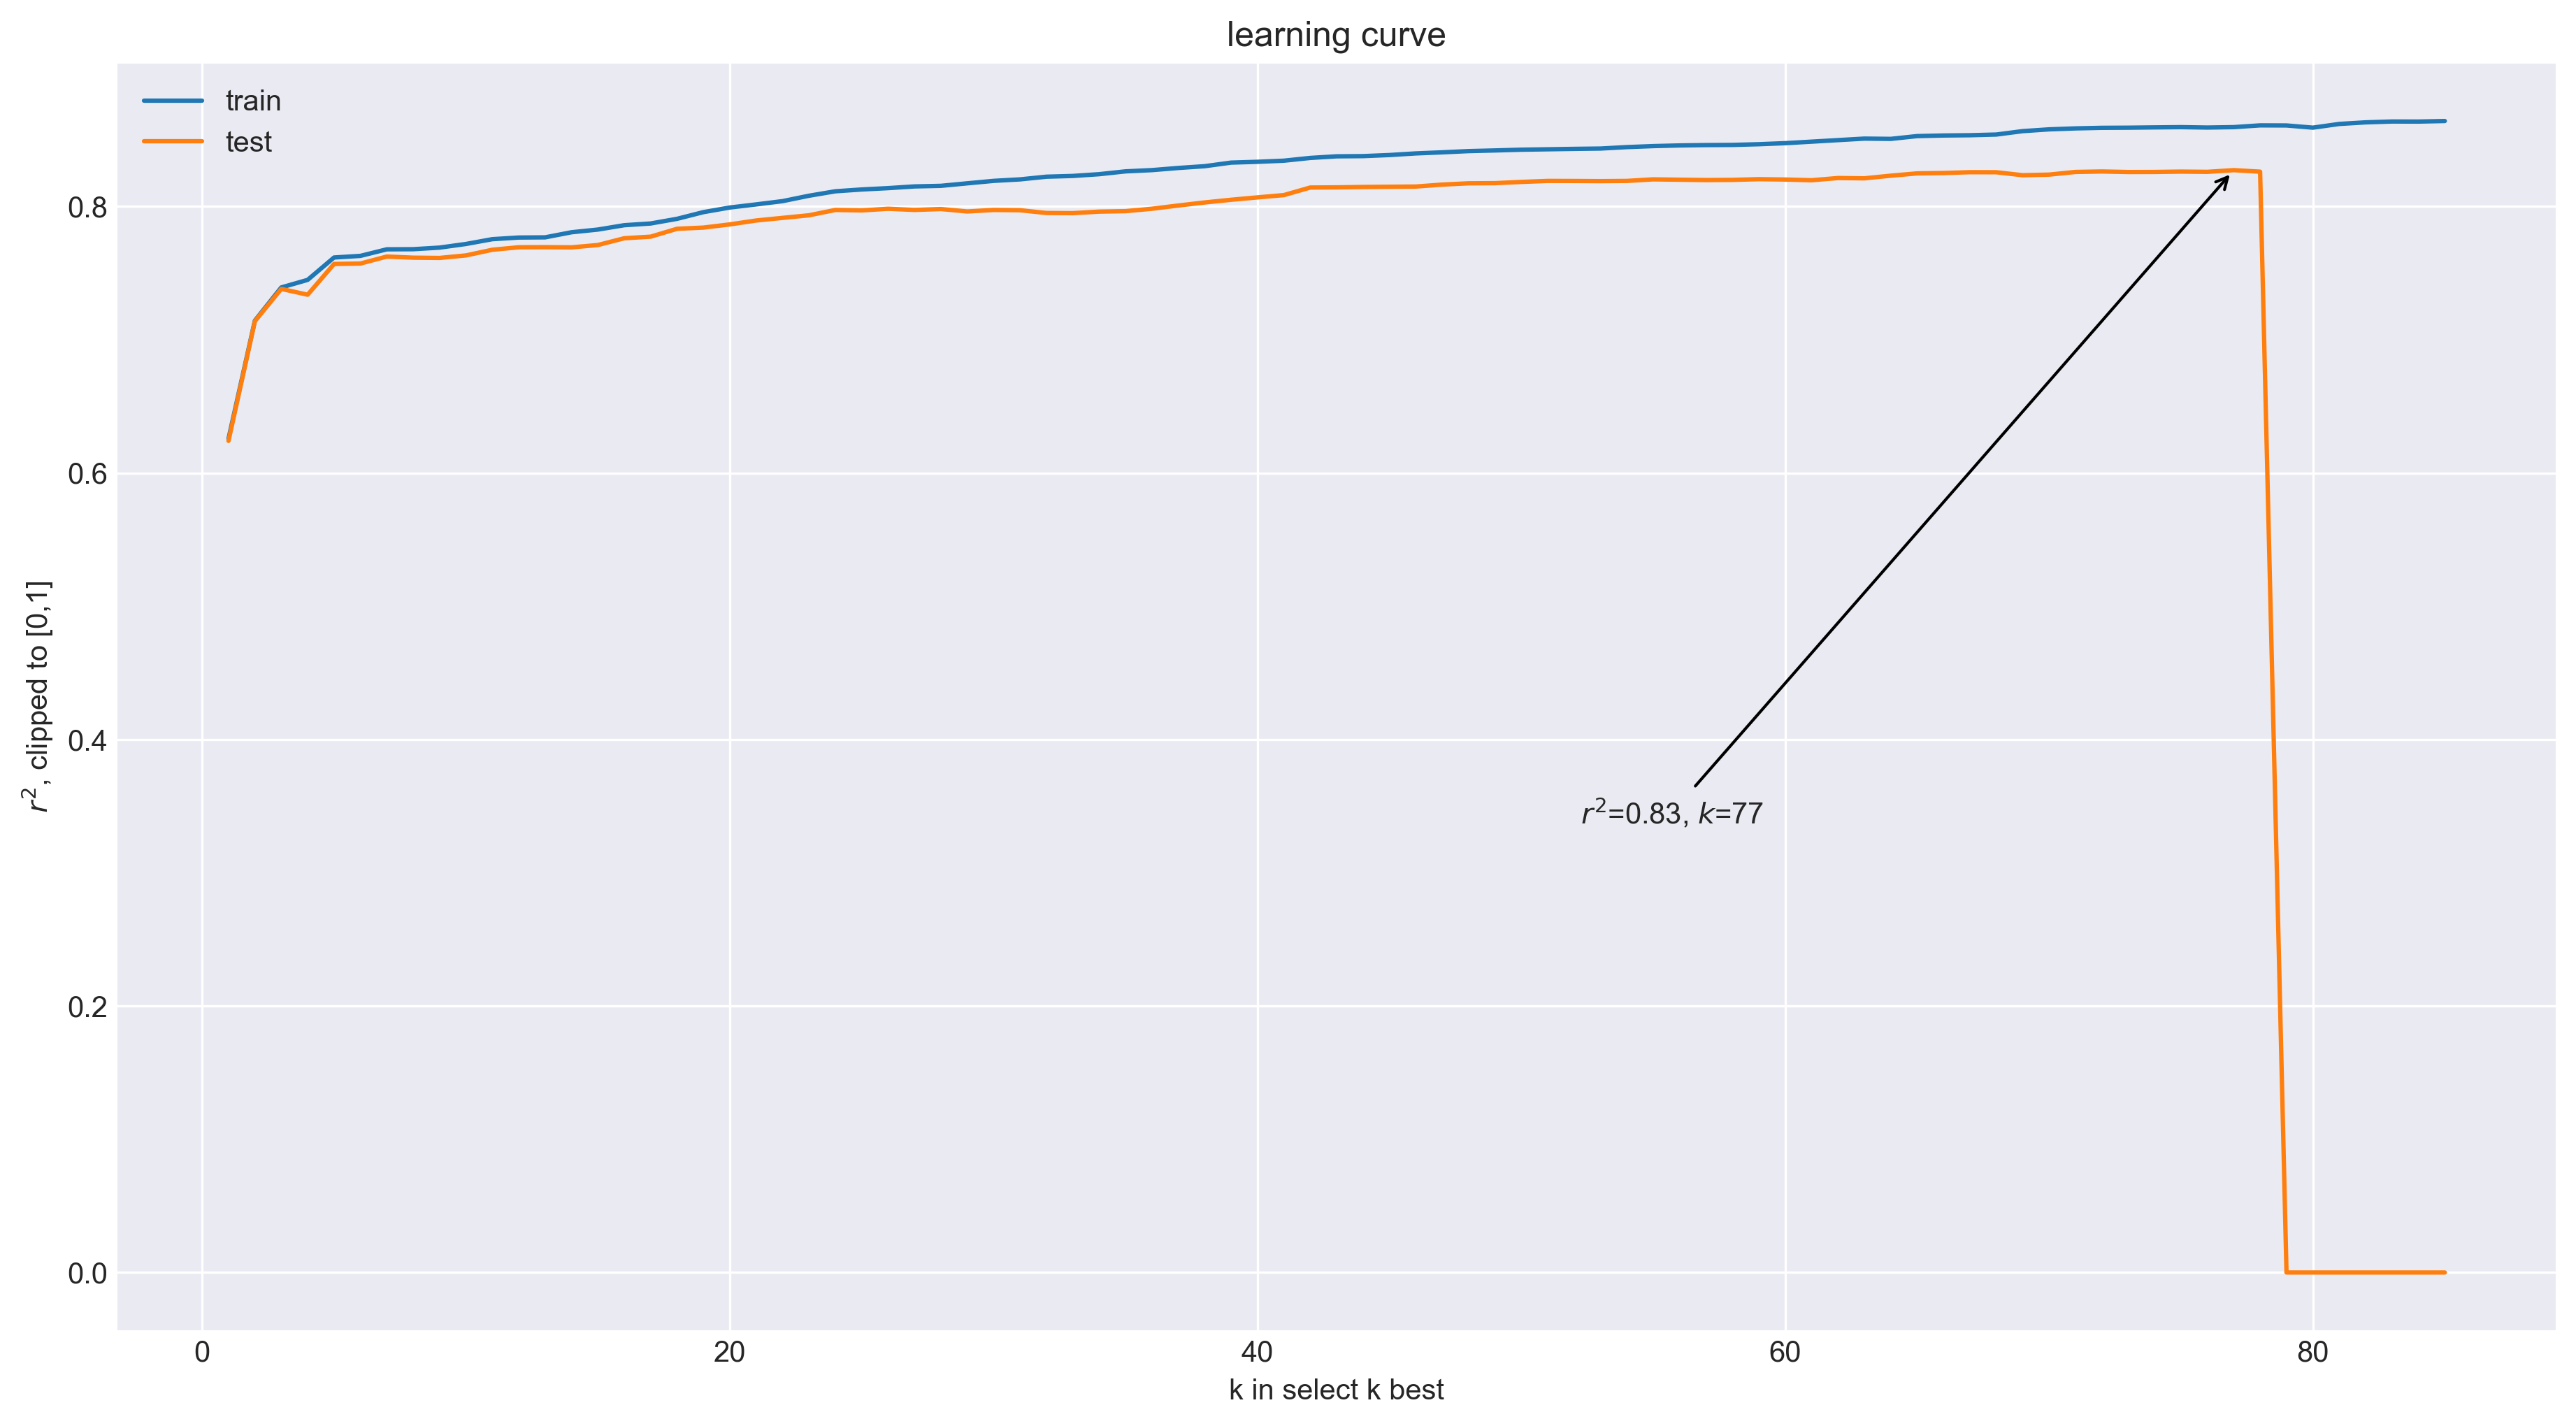

In [207]:
figsize(15, 8)


train_scores = []
test_scores = []
num_feats = 85
feat_range = np.arange(num_feats)+1
for num_f in feat_range:
    select_pipe.set_params(select__k=num_f)
    cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )    

plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")
xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();

### Visualizing Regularized Regression

#### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$

where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

In [188]:
ridge_pipe = pipeline.Pipeline([
     ("imp", preprocessing.Imputer()), 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [318]:
test_train_y = log(y)
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,test_train_y)

In [323]:
# alphas look best when logspaced

# alphas 3 to 7 worked well for non-logged y

cv_y = log(y)

alphas_num=20
cv_num=10

alphas = np.logspace(-20, 9, num=alphas_num)
coefs_ridge = []
train_scores_ridge = []
test_scores_ridge = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    ridge_pipe.set_params(ridge__alpha=alpha)
    # cross validate and store the results
    cv_result_ridge = model_selection.cross_validate(
        ridge_pipe, X=x, y=cv_y, cv=cv_num, return_train_score=True)
    # use np.maximum(., 0) to make sure the scores don't go below zero (makes for ugly plots tbh)
    train_scores_ridge.append(np.maximum(np.mean(cv_result_ridge['train_score']), 0))
    test_scores_ridge.append(np.maximum(np.mean(cv_result_ridge['test_score']), 0))
    
    # fit again to grab coefficients
    ridge_pipe.fit(x_train, y_train)
    coefs_ridge.append(ridge_pipe.named_steps["ridge"].coef_)

In [113]:
print(alphas)

[1.02329299e+00 1.87340459e+00 3.42975547e+00 6.27906150e+00
 1.14954590e+01 2.10454344e+01 3.85291540e+01 7.05376607e+01
 1.29137576e+02 2.36419999e+02 4.32828440e+02 7.92405294e+02
 1.45070446e+03 2.65589271e+03 4.86230397e+03 8.90171497e+03
 1.62969099e+04 2.98357419e+04 5.46221035e+04 1.00000000e+05]


/Users/etheredgej/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


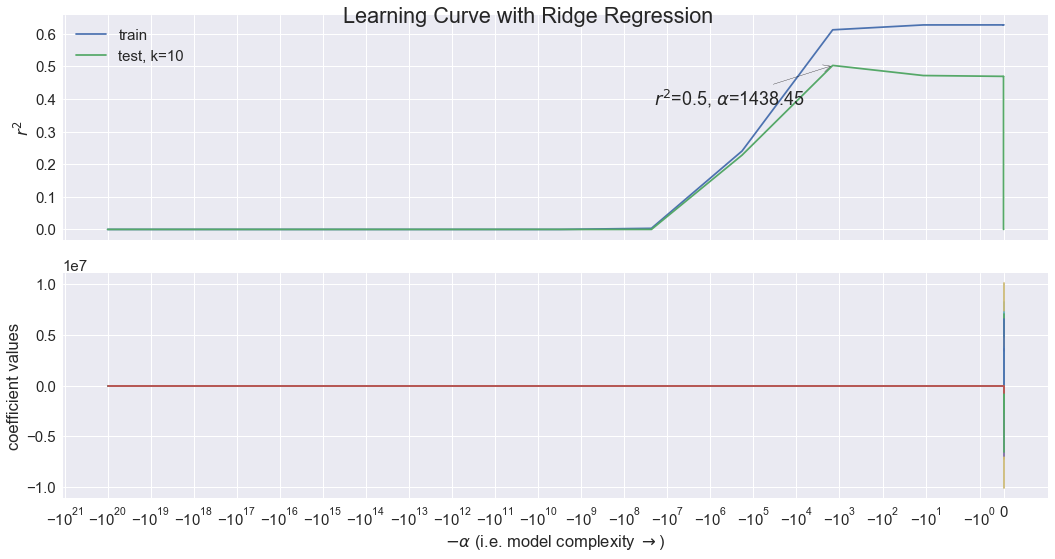

In [324]:
# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs_ridge, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores_ridge, label="train")
ax0.plot(-alphas, test_scores_ridge, label="test, k=10")
# find the index of the best score
best_ridge_i = np.argmax(test_scores_ridge)
# annotate score
ann_xy = (-alphas[best_ridge_i], test_scores_ridge[best_ridge_i])
ann_text = f"$r^2$={test_scores_ridge[best_ridge_i]:.2}, $\\alpha$={alphas[best_ridge_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")
plt.savefig("ridge.pdf")

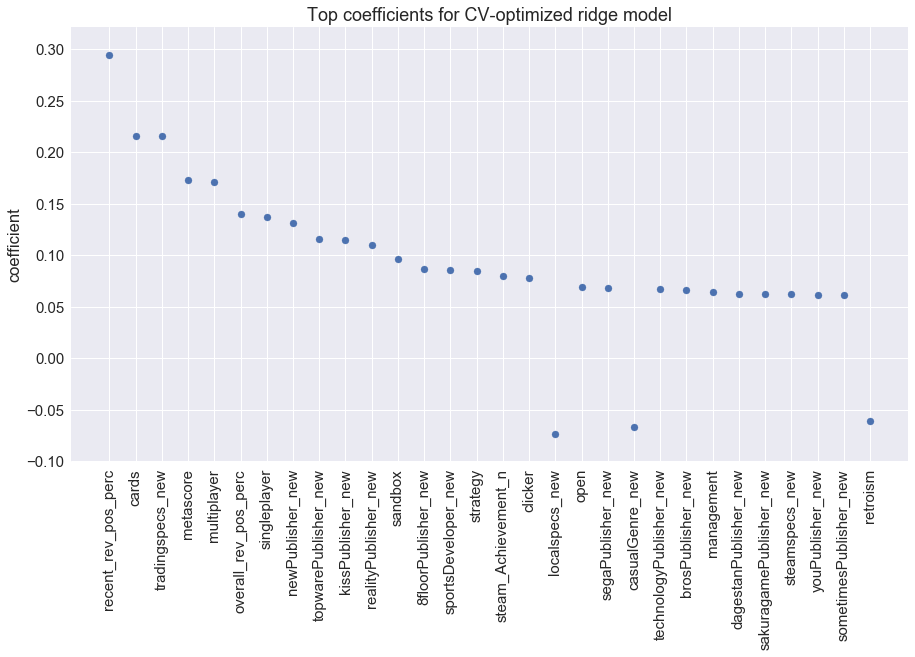

In [325]:
test_train_y = log(y)
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,test_train_y)

ridge_pipe.set_params(ridge__alpha=alphas[best_ridge_i])
ridge_pipe.fit(x_train, y_train)
# pred = ridge_pipe.predict(x_test)
# score = ridge_pipe.score(x_test, y_test)

var_support = ridge_pipe.named_steps["var"].get_support()
feat = x.columns[var_support]
coef = ridge_pipe.named_steps["ridge"].coef_
sort_i = argsort(-np.abs(coef))

figsize(15,8)
n_plot = 30
ind = np.arange(n_plot)

scatter(ind, coef[sort_i][:n_plot])
plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
plt.title("Top coefficients for CV-optimized ridge model")
plt.ylabel("coefficient");

In [326]:
# Now show the log-y r-squared

# rsquared = 1-SSE/SST = SSR/SST

pred = ridge_pipe.predict(x_test)

y_pred = exp(pred)

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared, SSR, SST)

0.007362582338128314 105740412479.9917 14361864849021.52


##### Now with the LASSO...

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. As mentioned above, another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

Let's check out the same process using the LASSO:

In [235]:
lasso_pipe = pipeline.Pipeline([
     ("imp", preprocessing.Imputer()), 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("lasso", linear_model.Lasso())
    ])

In [285]:
test_train_y = log(y)
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,test_train_y)

In [281]:
# alphas look best when logspaced

# alphas between 4 and 5 (between 4.25 and 4.5) worked for non-logged y

cv_y = log(y)

alphas_num=20
cv_num=10

alphas = np.logspace(-20, 0, num=alphas_num)
coefs = []
train_scores = []
test_scores = []

# loop through each of the 50 alphas
for i, alpha in enumerate(alphas):
    # set the alpha for our pipeline
    lasso_pipe.set_params(lasso__alpha=alpha)
    # cross validate and store the results
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=x, y=cv_y, cv=cv_num, return_train_score=True)
    # use np.maximum(., 0) to make sure the scores don't go below zero (makes for ugly plots tbh)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    
    # fit again to grab coefficients
    lasso_pipe.fit(x_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Obje

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/Users/etheredgej/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


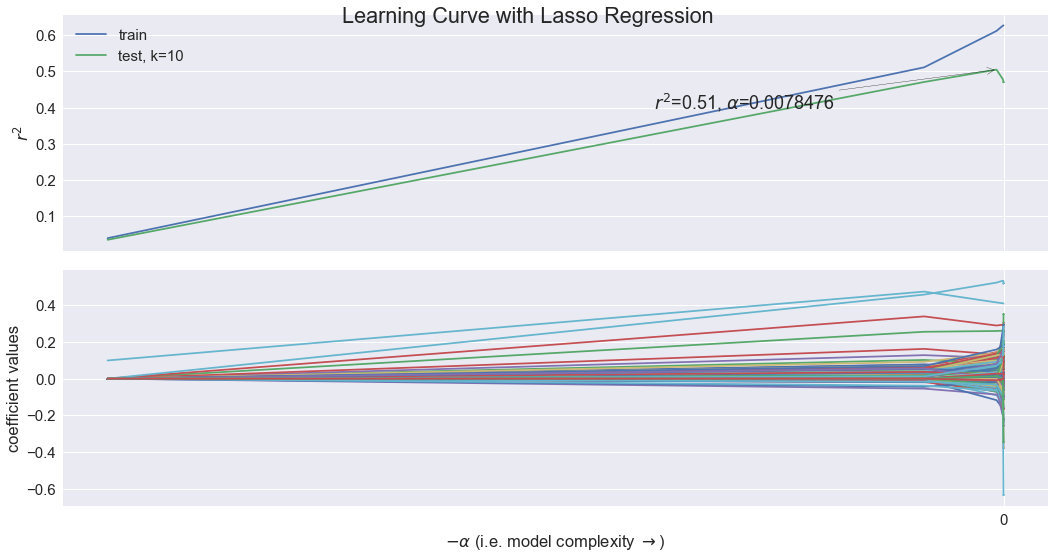

In [282]:
sns.set(font_scale=1.5)

# set up the figure. I'll do the learning curve above and coefficient path below
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
# list of arrays -> single array
coef_arr = np.squeeze(coefs, axis=1)
# grab the first axis
ax0 = axes.flat[0]
# plot train and test curves
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
# find the index of the best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

# grab the second axis
ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Lasso Regression")
plt.xscale("symlog")
plt.savefig("lasso.pdf")

In [ ]:
coefs

In [173]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
train_scores, valid_scores = validation_curve(Ridge(), np.isfinite(x), y, "alpha", np.logspace(-10, -5, 3))

In [175]:
print(train_scores)

[[2.19889809e-05 1.14759978e-04 3.35781717e-05]
 [2.19889802e-05 1.14759967e-04 3.35781694e-05]
 [2.84368296e-06 9.55746346e-06 4.33416848e-06]]


In [176]:
print(valid_scores)

[[-6.13351138e-04 -3.41376241e-05 -8.32573601e-03]
 [-6.13338505e-04 -3.41203413e-05 -8.32512065e-03]
 [-6.26420001e-04 -9.32662479e-06 -7.47304986e-03]]


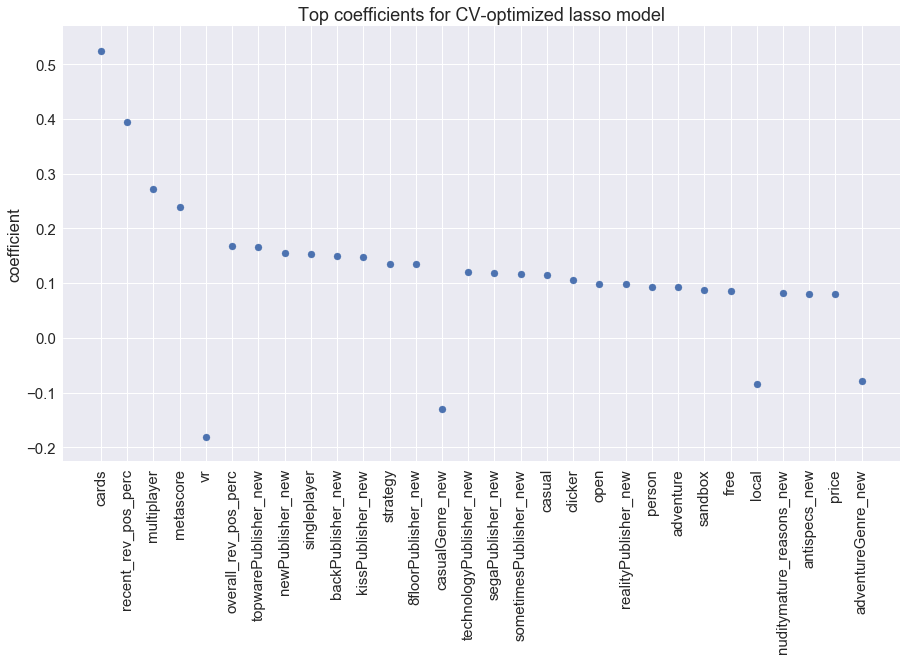

In [283]:
test_train_y = log(y)
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,test_train_y)
lasso_pipe.set_params(lasso__alpha=alphas[best_i])
lasso_pipe.fit(x_train, y_train)
# pred = lasso_pipe.predict(x_test)
# score = lasso_pipe.score(x_test, y_test)

var_support = lasso_pipe.named_steps["var"].get_support()
feat = x.columns[var_support]
coef = lasso_pipe.named_steps["lasso"].coef_
sort_i = argsort(-np.abs(coef))

figsize(15,8)
n_plot = 30
ind = np.arange(n_plot)

scatter(ind, coef[sort_i][:n_plot])
plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
plt.title("Top coefficients for CV-optimized lasso model")
plt.ylabel("coefficient");

In [284]:
# rsquared = 1-SSE/SST = SSR/SST

pred = lasso_pipe.predict(x_test)

y_pred = exp(pred)

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared, SSR, SST)

0.0241810412917473 347284846940.6835 14361864849021.52


In [257]:
lasso_pipe.set_params(lasso__alpha=alphas[best_i])

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('var', VarianceThreshold(threshold=0.0)), ('lasso', Lasso(alpha=0.012742749857031322, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [119]:
import statsmodels.api as sm

/Users/etheredgej/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [219]:
# Create your model
model = sm.OLS(log(y),np.isfinite(x))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import scipy.stats as stats
%matplotlib inline

In [167]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
        
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
    
    plt.subplot(1, 3, 1)
    plt.scatter(x.overall_reviews_n,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [166]:
len(np.isfinite(x))
x.size
x.overall_reviews_n

0         15.0
1         19.0
2        272.0
3         54.0
4         80.0
5       1387.0
6         25.0
7         38.0
8          0.0
9         12.0
10       794.0
11       794.0
12       296.0
13        14.0
14        30.0
15      1292.0
16      5442.0
17       330.0
18        43.0
19      1726.0
20      1908.0
21      1486.0
22       634.0
23       241.0
24       199.0
25        84.0
26        15.0
27       115.0
28      1326.0
29         0.0
         ...  
7265     535.0
7266     347.0
7267    1123.0
7268      65.0
7269     135.0
7270      54.0
7271      15.0
7272     112.0
7273      27.0
7274      59.0
7275    2028.0
7276     722.0
7277     829.0
7278     519.0
7279     154.0
7280     140.0
7281     372.0
7282     449.0
7283     879.0
7284    3582.0
7285    1088.0
7286    1302.0
7287     567.0
7288     478.0
7289     524.0
7290      49.0
7291     852.0
7292     334.0
7293      35.0
7294    1317.0
Name: overall_reviews_n, Length: 7295, dtype: float64

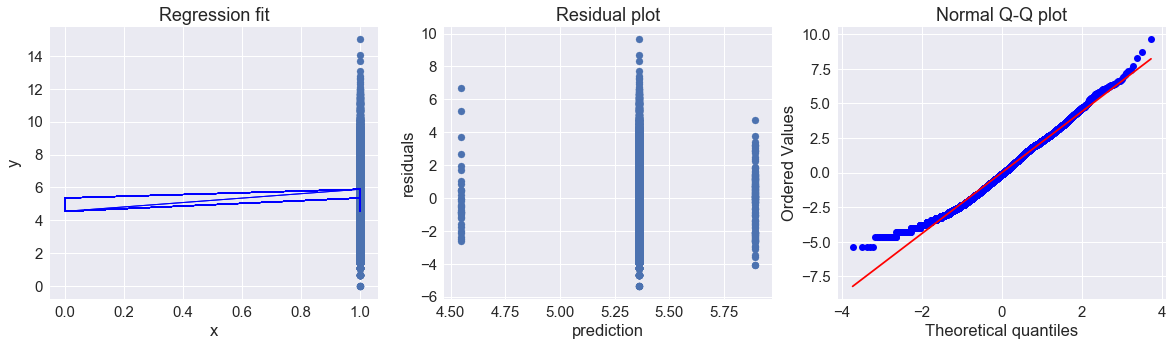

In [211]:
diagnostic_plot(np.isfinite(x),log(y))

Text(0.5,1,'Normal Q-Q plot')

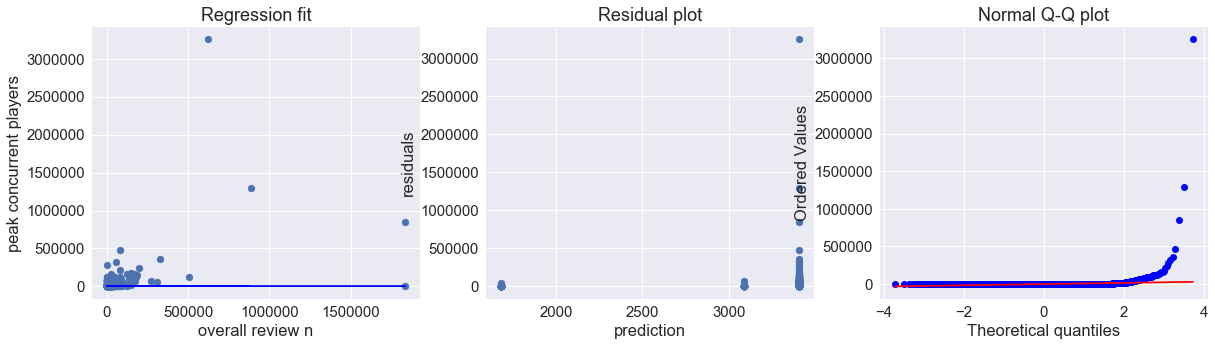

In [276]:
plt_x = np.isfinite(x)
scatter_x = x.overall_reviews_n
plt_y = y

plt.figure(figsize=(20,5))

rgr = LinearRegression()
rgr.fit(plt_x,plt_y)
pred = rgr.predict(plt_x)

plt.subplot(1, 3, 1)
plt.scatter(scatter_x,plt_y)
plt.plot(scatter_x, pred, color='blue',linewidth=1)
plt.title("Regression fit")
plt.xlabel("overall review n")
plt.ylabel("peak concurrent players")

plt.subplot(1, 3, 2)
res = plt_y - pred
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [279]:
# calculating r-squared

# back-transforming y

# len(pred)
y_pred = exp(pred)

# rsquared = 1-SSE/SST = SSR/SST

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared)

inf


In [280]:
# rsquared = 1-SSE/SST = SSR/SST

y_pred = exp(pred)

ybar = np.mean(y)
SSR = np.sum((y_pred - ybar)**2)
SST = np.sum((y - ybar)**2)
rsquared = SSR / SST
print(rsquared, SSR, SST)

inf inf 14361864849021.52


In [ ]:
# develop OLS with Sklearn
lr = LinearRegression()
fit = lr.fit(np.isfinite(x),y)

# Plot your predicted values on the x-axis, and your residuals on the y-axis

data['predict']=fit.predict(np.isfinite(x))
data['resid']=data.cnt-data.predict
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))